# R-CNN object detection with Keras, TensorFlow, and Deep Learning
## Steps to implementing an R-CNN object detector with Keras and TensorFlow
<image src="images/training_simple_rcnn_pipeline_steps.png">

With that said, below you can see our 6-step process to implementing an R-CNN object detector:

* Step #1: Build an object detection dataset using Selective Search
* Step #2: Fine-tune a classification network (originally trained on ImageNet) for object detection
* Step #3: Create an object detection inference script that utilizes Selective Search to propose regions that could contain an object that we would like to detect
* Step #4: Use our fine-tuned network to classify each region proposed via Selective Search
* Step #5: Apply non-maxima suppression to suppress weak, overlapping bounding boxes
* Step #6: Return the final object detection results

## Our object detection dataset

### Import Packages

In [24]:
# import the necessary packages
from pyimagesearch.nms import non_max_suppression
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from bs4 import BeautifulSoup
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import imutils
import pickle
import cv2
import os

### Function to display images in Jupyter Notebooks and Google Colab

In [25]:
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Implementing our object detection configuration file

In [26]:
class Config:
    # define the base path to the *original* input dataset and then use
    # the base path to derive the image and annotations directories
    ORIG_BASE_PATH = "data/raccoons"
    ORIG_IMAGES = os.path.sep.join([ORIG_BASE_PATH, "images"])
    ORIG_ANNOTS = os.path.sep.join([ORIG_BASE_PATH, "annotations"])

    # define the base path to the *new* dataset after running our dataset
    # builder scripts and then use the base path to derive the paths to
    # our output class label directories
    BASE_PATH = "dataset"
    POSITVE_PATH = os.path.sep.join([BASE_PATH, "raccoon"])
    NEGATIVE_PATH = os.path.sep.join([BASE_PATH, "no_raccoon"])

    # define the number of max proposals used when running selective
    # search for (1) gathering training data and (2) performing inference
    MAX_PROPOSALS = 2000
    MAX_PROPOSALS_INFER = 200

    # define the maximum number of positive and negative images to be
    # generated from each image
    MAX_POSITIVE = 30
    MAX_NEGATIVE = 10

    # initialize the input dimensions to the network
    INPUT_DIMS = (224, 224)
    # define the path to the output model and label binarizer
    MODEL_PATH = "output/raccoon_detector.h5"
    ENCODER_PATH = "output/label_encoder.pickle"

    # define the minimum probability required for a positive prediction
    # (used to filter out false-positive predictions)
    MIN_PROBA = 0.99

# instantiate our Config object
config = Config()

### Measuring object detection accuracy with Intersection over Union (IoU)

In order to measure how “good” a job our object detector is doing at predicting bounding boxes, we’ll be using the Intersection over Union (IoU) metric.

The IoU method computes the ratio of the area of overlap to the area of the union between the predicted bounding box and the ground-truth bounding box:

<image src="images/iou_equation.png">

Figure 4: Computing the Intersection over Union is as simple as dividing the area of overlap between the bounding boxes by the area of union. (image source)
Examining this equation, you can see that Intersection over Union is simply a ratio:

* In the numerator, we compute the area of overlap between the predicted bounding box and the ground-truth bounding box.
* The denominator is the area of union, or more simply, the area encompassed by both the predicted bounding box and the ground-truth bounding box.
* Dividing the area of overlap by the area of union yields our final score — the Intersection over Union (hence the name).

We’ll use IoU to measure object detection accuracy, including how much a given Selective Search proposal overlaps with a ground-truth bounding box (which is useful when we go to generate positive and negative examples for our training data).



In [27]:
def compute_iou(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])

	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the intersection area
	iou = interArea / float(boxAArea + boxBArea - interArea)

	# return the intersection over union value
	return iou

### Implementing our object detection dataset builder script

<image src="images/training_simple_rcnn_build_dataset_steps.png">

Before we can create our R-CNN object detector, we first need to build our dataset, accomplishing Step #1 from our list of six steps for today’s tutorial:

* 1. Accept our input raccoons dataset
* 2. Loop over all images in the dataset
    * 2a. Load thea given input image
    * 2b. Load and parse the bounding box coordinates for any raccoons in the input image
* 3. Run Selective Search on the input image
* 4. Use IoU to determine which region proposals from Selective Search sufficiently overlap with the ground-truth bounding boxes and which ones do not
* 5. Save region proposals as overlapping (contains raccoon) or not (no raccoon)

In [28]:
# loop over the output positive and negative directories
for dirPath in (config.POSITVE_PATH, config.NEGATIVE_PATH):
	# if the output directory does not exist yet, create it
	if not os.path.exists(dirPath):
		os.makedirs(dirPath)

# grab all image paths in the input images directory
imagePaths = list(paths.list_images(config.ORIG_IMAGES))

# initialize the total number of positive and negative images we have
# saved to disk so far
totalPositive = 0
totalNegative = 0

In [29]:
# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
	# show a progress report
	print("[INFO] processing image {}/{}...".format(i + 1,
		len(imagePaths)))

	# extract the filename from the file path and use it to derive
	# the path to the XML annotation file
	filename = imagePath.split(os.path.sep)[-1]
	filename = filename[:filename.rfind(".")]
	annotPath = os.path.sep.join([config.ORIG_ANNOTS,
		"{}.xml".format(filename)])

	# load the annotation file, build the soup, and initialize our
	# list of ground-truth bounding boxes
	contents = open(annotPath).read()
	soup = BeautifulSoup(contents, "html.parser")
	gtBoxes = []

	# extract the image dimensions
	w = int(soup.find("width").string)
	h = int(soup.find("height").string)

    # loop over all 'object' elements
	for o in soup.find_all("object"):
		# extract the label and bounding box coordinates
		label = o.find("name").string
		xMin = int(o.find("xmin").string)
		yMin = int(o.find("ymin").string)
		xMax = int(o.find("xmax").string)
		yMax = int(o.find("ymax").string)

		# truncate any bounding box coordinates that may fall
		# outside the boundaries of the image
		xMin = max(0, xMin)
		yMin = max(0, yMin)
		xMax = min(w, xMax)
		yMax = min(h, yMax)

		# update our list of ground-truth bounding boxes
		gtBoxes.append((xMin, yMin, xMax, yMax))

    # load the input image from disk
	image = cv2.imread(imagePath)

	# run selective search on the image and initialize our list of
	# proposed boxes
	ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
	ss.setBaseImage(image)
	ss.switchToSelectiveSearchFast()
	rects = ss.process()
	proposedRects= []

	# loop over the rectangles generated by selective search
	for (x, y, w, h) in rects:
		# convert our bounding boxes from (x, y, w, h) to (startX,
		# startY, startX, endY)
		proposedRects.append((x, y, x + w, y + h))

    # initialize counters used to count the number of positive and
	# negative ROIs saved thus far
	positiveROIs = 0
	negativeROIs = 0

	# loop over the maximum number of region proposals
	for proposedRect in proposedRects[:config.MAX_PROPOSALS]:
		# unpack the proposed rectangle bounding box
		(propStartX, propStartY, propEndX, propEndY) = proposedRect

		# loop over the ground-truth bounding boxes
		for gtBox in gtBoxes:
			# compute the intersection over union between the two
			# boxes and unpack the ground-truth bounding box
			iou = compute_iou(gtBox, proposedRect)
			(gtStartX, gtStartY, gtEndX, gtEndY) = gtBox

			# initialize the ROI and output path
			roi = None
			outputPath = None

            # check to see if the IOU is greater than 70% *and* that
			# we have not hit our positive count limit
			if iou > 0.7 and positiveROIs <= config.MAX_POSITIVE:
				# extract the ROI and then derive the output path to
				# the positive instance
				roi = image[propStartY:propEndY, propStartX:propEndX]
				filename = "{}.png".format(totalPositive)
				outputPath = os.path.sep.join([config.POSITVE_PATH,
					filename])

				# increment the positive counters
				positiveROIs += 1
				totalPositive += 1

            # determine if the proposed bounding box falls *within*
			# the ground-truth bounding box
			fullOverlap = propStartX >= gtStartX
			fullOverlap = fullOverlap and propStartY >= gtStartY
			fullOverlap = fullOverlap and propEndX <= gtEndX
			fullOverlap = fullOverlap and propEndY <= gtEndY

            # check to see if there is not full overlap *and* the IoU
			# is less than 5% *and* we have not hit our negative
			# count limit
			if not fullOverlap and iou < 0.05 and \
				negativeROIs <= config.MAX_NEGATIVE:
				# extract the ROI and then derive the output path to
				# the negative instance
				roi = image[propStartY:propEndY, propStartX:propEndX]
				filename = "{}.png".format(totalNegative)
				outputPath = os.path.sep.join([config.NEGATIVE_PATH,
					filename])

				# increment the negative counters
				negativeROIs += 1
				totalNegative += 1

            # check to see if both the ROI and output path are valid
			if roi is not None and outputPath is not None:
				# resize the ROI to the input dimensions of the CNN
				# that we'll be fine-tuning, then write the ROI to
				# disk
				roi = cv2.resize(roi, config.INPUT_DIMS,
					interpolation=cv2.INTER_CUBIC)
				cv2.imwrite(outputPath, roi)

[INFO] processing image 1/200...
[INFO] processing image 2/200...
[INFO] processing image 3/200...
[INFO] processing image 4/200...
[INFO] processing image 5/200...
[INFO] processing image 6/200...
[INFO] processing image 7/200...
[INFO] processing image 8/200...
[INFO] processing image 9/200...
[INFO] processing image 10/200...
[INFO] processing image 11/200...
[INFO] processing image 12/200...
[INFO] processing image 13/200...
[INFO] processing image 14/200...
[INFO] processing image 15/200...
[INFO] processing image 16/200...
[INFO] processing image 17/200...
[INFO] processing image 18/200...
[INFO] processing image 19/200...
[INFO] processing image 20/200...
[INFO] processing image 21/200...
[INFO] processing image 22/200...
[INFO] processing image 23/200...
[INFO] processing image 24/200...
[INFO] processing image 25/200...
[INFO] processing image 26/200...
[INFO] processing image 27/200...
[INFO] processing image 28/200...
[INFO] processing image 29/200...
[INFO] processing image

### Fine-tuning a network for object detection with Keras and TensorFlow

For the purposes of this tutorial, I’ve chosen to fine-tune the MobileNet V2 CNN, which is pre-trained on the 1,000-class ImageNet dataset. I recommend that you read up on the concepts of transfer learning and fine-tuning if you are not familiar with them:

* Transfer Learning with Keras and Deep Learning (be sure to read from the beginning through the “Two types of transfer learning: feature extraction and fine tuning” section at a minimum)
* Fine-tuning with Keras and Deep Learning (I highly recommend reading this tutorial in its entirety)

The result of fine-tuning MobileNet will be a classifier that distinguishes between our raccoon and no_raccoon classes.

In [30]:
# construct the argument parser and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-p", "--plot", type=str, default="plot.png",
#	help="path to output loss/accuracy plot")
#args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"plot": "output/rcnn_plot.png"
}

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 5
BS = 32

In [31]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class labels
print("[INFO] loading images...")
imagePaths = list(paths.list_images(config.BASE_PATH))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=config.INPUT_DIMS)
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

[INFO] loading images...


In [32]:
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [33]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [34]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/5
94/94 [==============================] - 35s 345ms/step - loss: 0.3962 - accuracy: 0.8511 - val_loss: 0.0488 - val_accuracy: 0.9960
Epoch 2/5
94/94 [==============================] - 31s 334ms/step - loss: 0.0513 - accuracy: 0.9943 - val_loss: 0.0232 - val_accuracy: 0.9960
Epoch 3/5
94/94 [==============================] - 32s 336ms/step - loss: 0.0261 - accuracy: 0.9967 - val_loss: 0.0203 - val_accuracy: 0.9960
Epoch 4/5
94/94 [==============================] - 31s 333ms/step - loss: 0.0143 - accuracy: 0.9982 - val_loss: 0.0159 - val_accuracy: 0.9960
Epoch 5/5
94/94 [==============================] - 31s 332ms/step - loss: 0.0145 - accuracy: 0.9965 - val_loss: 0.0166 - val_accuracy: 0.9960


In [35]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

  no_raccoon       1.00      0.99      1.00       440
     raccoon       0.99      1.00      1.00       312

    accuracy                           1.00       752
   macro avg       1.00      1.00      1.00       752
weighted avg       1.00      1.00      1.00       752



In [36]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save(config.MODEL_PATH, save_format="h5")

# serialize the label encoder to disk
print("[INFO] saving label encoder...")
f = open(config.ENCODER_PATH, "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] saving mask detector model...
[INFO] saving label encoder...


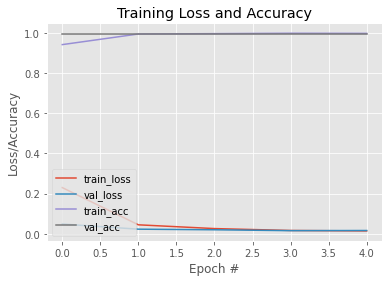

In [37]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])
plt.show()

### Putting the pieces together: Implementing our R-CNN object detection inference script

In [38]:
# construct the argument parser and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-i", "--image", required=True,
#	help="path to input image")
#args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"image": "data/raccons/test/raccoon_01.jpg"
}

In [39]:
# load the our fine-tuned model and label binarizer from disk
print("[INFO] loading model and label binarizer...")
model = load_model(config.MODEL_PATH)
lb = pickle.loads(open(config.ENCODER_PATH, "rb").read())

# load the input image from disk
image = cv2.imread(args["image"])
image = imutils.resize(image, width=500)

# run selective search on the image to generate bounding box proposal
# regions
print("[INFO] running selective search...")
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()

[INFO] loading model and label binarizer...
[INFO] running selective search...


In [40]:
# initialize the list of region proposals that we'll be classifying
# along with their associated bounding boxes
proposals = []
boxes = []

# loop over the region proposal bounding box coordinates generated by
# running selective search
for (x, y, w, h) in rects[:config.MAX_PROPOSALS_INFER]:
	# extract the region from the input image, convert it from BGR to
	# RGB channel ordering, and then resize it to the required input
	# dimensions of our trained CNN
	roi = image[y:y + h, x:x + w]
	roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
	roi = cv2.resize(roi, config.INPUT_DIMS,
		interpolation=cv2.INTER_CUBIC)

	# further preprocess the ROI
	roi = img_to_array(roi)
	roi = preprocess_input(roi)

	# update our proposals and bounding boxes lists
	proposals.append(roi)
	boxes.append((x, y, x + w, y + h))

In [41]:
# convert the proposals and bounding boxes into NumPy arrays
proposals = np.array(proposals, dtype="float32")
boxes = np.array(boxes, dtype="int32")
print("[INFO] proposal shape: {}".format(proposals.shape))

# classify each of the proposal ROIs using fine-tuned model
print("[INFO] classifying proposals...")
proba = model.predict(proposals)

[INFO] proposal shape: (200, 224, 224, 3)
[INFO] classifying proposals...


In [42]:
# find the index of all predictions that are positive for the
# "raccoon" class
print("[INFO] applying NMS...")
labels = lb.classes_[np.argmax(proba, axis=1)]
idxs = np.where(labels == "raccoon")[0]

# use the indexes to extract all bounding boxes and associated class
# label probabilities associated with the "raccoon" class
boxes = boxes[idxs]
proba = proba[idxs][:, 1]

# further filter indexes by enforcing a minimum prediction
# probability be met
idxs = np.where(proba >= config.MIN_PROBA)
boxes = boxes[idxs]
proba = proba[idxs]

[INFO] applying NMS...


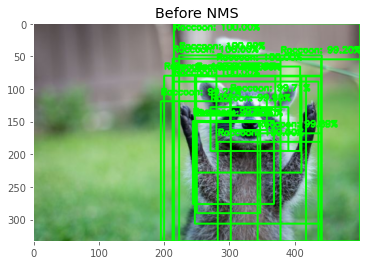

In [43]:
# clone the original image so that we can draw on it
clone = image.copy()

# loop over the bounding boxes and associated probabilities
for (box, prob) in zip(boxes, proba):
	# draw the bounding box, label, and probability on the image
	(startX, startY, endX, endY) = box
	cv2.rectangle(clone, (startX, startY), (endX, endY),
		(0, 255, 0), 2)
	y = startY - 10 if startY - 10 > 10 else startY + 10
	text= "Raccoon: {:.2f}%".format(prob * 100)
	cv2.putText(clone, text, (startX, y),
		cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

# show the output after *before* running NMS
plt_imshow("Before NMS", clone)

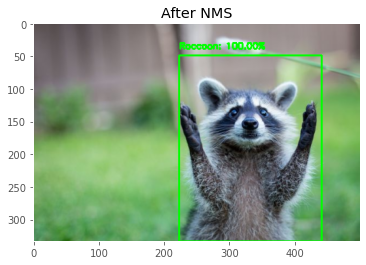

In [44]:
# run non-maxima suppression on the bounding boxes
boxIdxs = non_max_suppression(boxes, proba)

# loop over the bounding box indexes
for i in boxIdxs:
	# draw the bounding box, label, and probability on the image
	(startX, startY, endX, endY) = boxes[i]
	cv2.rectangle(image, (startX, startY), (endX, endY),
		(0, 255, 0), 2)
	y = startY - 10 if startY - 10 > 10 else startY + 10
	text= "Raccoon: {:.2f}%".format(proba[i] * 100)
	cv2.putText(image, text, (startX, y),
		cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

# show the output image *after* running NMS
plt_imshow("After NMS", image)